# Einführung in neuronale Netze mit Keras

In diesem Notebook wird die Keras API vorgestellt und ein kleines neuronales Netzwerk trainiert. Dokumentation und weitere Tutorials gibt es auf https://keras.io/.

In [1]:
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

pd.options.mode.chained_assignment = None  # default='warn'
sns.set_context("talk")

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


fetch_housing_data()

In [3]:
housing_data = pd.read_csv("./datasets/housing/housing.csv")
housing_data.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
images_path = os.path.join("./", "images")
os.makedirs(images_path, exist_ok=True)
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/california.png', <http.client.HTTPMessage at 0x7f758b9e7a00>)

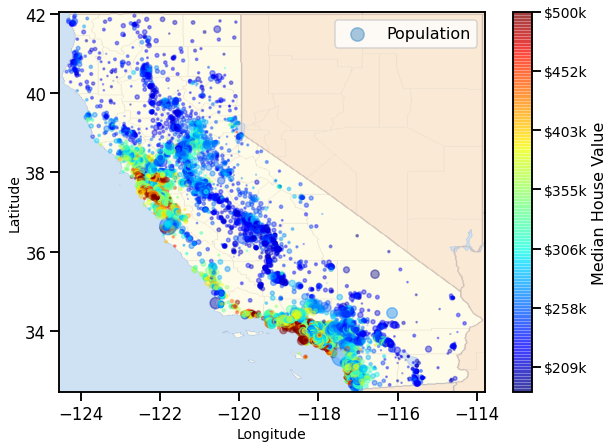

In [6]:
import matplotlib.image as mpimg

california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing_data.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    figsize=(10, 7),
    s=housing_data["population"] / 100,
    label="Population",
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=False,
    alpha=0.4,
)
plt.imshow(
    california_img,
    extent=[-124.55, -113.80, 32.45, 42.05],
    alpha=0.5,
    cmap=plt.get_cmap("jet"),
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing_data["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values / prices.max())
cbar.ax.set_yticklabels(["$%dk" % (round(v / 1000)) for v in tick_values], fontsize=14)
cbar.set_label("Median House Value", fontsize=16)

plt.legend(fontsize=16)
plt.show()

# prepare data

In [7]:
housing_data.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

<AxesSubplot:>

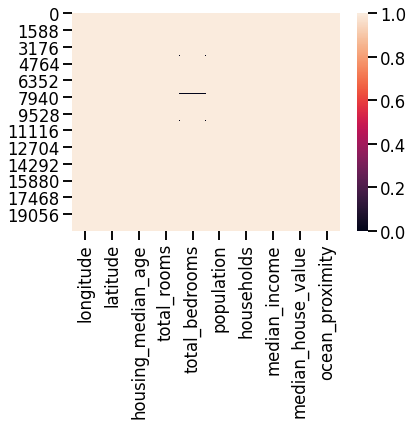

In [8]:
sns.heatmap(housing_data.notna())

In [9]:
housing_data = housing_data.dropna()


# Training a single Neuron with the Keras API

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

X = housing_data.drop(
    columns=["median_house_value", "ocean_proximity", ]
)
y = housing_data["median_house_value"].copy()
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

X_train = scaler.fit_transform(X_train)
y_train = y_train.values

X_test = scaler.transform(X_test)
y_test = y_test.values

In [11]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462


In [12]:
X_train.shape  # (samples/instances, features)

(14303, 8)

In [13]:
X_train.shape[1]

8

In [14]:
neuron_model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],), name="Input"),
    keras.layers.Dense(1, activation="linear", name="Neuron")
])

## Woher kommen die 9 Parameter?


In [15]:
neuron_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Neuron (Dense)               (None, 1)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


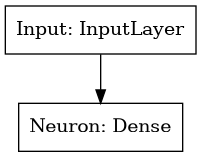

In [16]:
!pip install pydot
keras.utils.plot_model(neuron_model, "single_neuron.png")

In [17]:
neuron_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=5e-4),
    loss=keras.losses.MeanSquaredError(),
    metrics=keras.losses.MeanAbsoluteError(),
)

In [18]:
history = neuron_model.fit(
    x=X_train, y=y_train, batch_size=64, epochs=30, validation_split=0.3
)

Epoch 1/30
157/157 [==============================] - 1s 3ms/step - loss: 51908981410.0253 - mean_absolute_error: 196975.9199 - val_loss: 43149791232.0000 - val_mean_absolute_error: 178174.3750
Epoch 2/30
157/157 [==============================] - 0s 768us/step - loss: 40454375709.1646 - mean_absolute_error: 171196.5766 - val_loss: 33341376512.0000 - val_mean_absolute_error: 152626.6406
Epoch 3/30
157/157 [==============================] - 0s 721us/step - loss: 30635083296.4051 - mean_absolute_error: 144578.1099 - val_loss: 26145470464.0000 - val_mean_absolute_error: 130891.0703
Epoch 4/30
157/157 [==============================] - 0s 739us/step - loss: 23908588544.0000 - mean_absolute_error: 123231.3091 - val_loss: 20864636928.0000 - val_mean_absolute_error: 112735.2969
Epoch 5/30
157/157 [==============================] - 0s 730us/step - loss: 19777686489.1139 - mean_absolute_error: 108313.9125 - val_loss: 16987812864.0000 - val_mean_absolute_error: 98124.2891
Epoch 6/30
157/157 [===

In [19]:
history.history["mean_absolute_error"]

[191094.375,
 163123.875,
 139563.125,
 119669.9375,
 103266.6640625,
 90444.9453125,
 80553.734375,
 73140.734375,
 67803.9609375,
 63871.95703125,
 61134.11328125,
 59293.4765625,
 57866.60546875,
 56957.71875,
 56337.5546875,
 55935.29296875,
 55598.29296875,
 55345.1328125,
 55226.35546875,
 55114.18359375,
 55055.23046875,
 55038.52734375,
 54983.30078125,
 54908.69921875,
 54872.4453125,
 54852.73828125,
 54720.67578125,
 54670.36328125,
 54583.8984375,
 54577.515625]

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


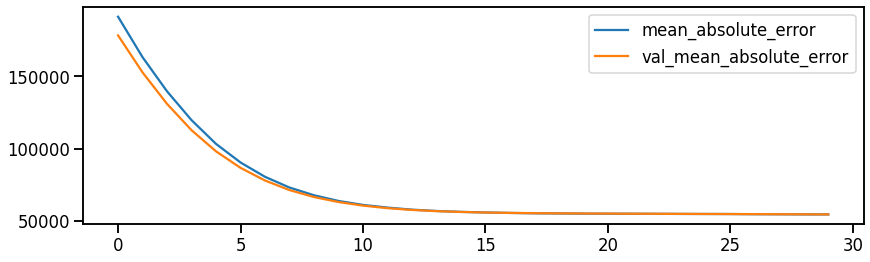

In [20]:
print(history.history.keys())
plt.figure(figsize=(14, 4))
series = history.history["mean_absolute_error"]
plt.plot(range(len(series)), series, label="mean_absolute_error")
series = history.history["val_mean_absolute_error"]
plt.plot(range(len(series)), series, label="val_mean_absolute_error")
plt.legend()
plt.show()

In [21]:
neuron_model.evaluate(X_train, y_train)

447/447 [==============================] - 0s 382us/step - loss: 5545498624.0000 - mean_absolute_error: 54638.7188


[5545498624.0, 54638.71875]

In [22]:
neuron_model.evaluate(X_test, y_test)

192/192 [==============================] - 0s 390us/step - loss: 5491870208.0000 - mean_absolute_error: 54038.2148


[5491870208.0, 54038.21484375]

## Training a small Network with the Keras API

In [23]:
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, models

In [24]:
X_train.shape

(14303, 8)

In [25]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential

network = Sequential(
    [
        Dense(10, input_shape = [X_train.shape[1]], activation="relu"),
        Dense(10, activation="tanh"),
        Dense(1, activation="linear"),
    ]
)
network.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [26]:
network.compile(
    optimizer=keras.optimizers.SGD(learning_rate=5e-4),
#     optimizer='nadam',
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [27]:
history = network.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_split=0.3)

Epoch 1/25
313/313 [==============================] - 1s 1ms/step - loss: 205471.5963 - mean_absolute_error: 205471.5963 - val_loss: 207627.4531 - val_mean_absolute_error: 207627.4531
Epoch 2/25
313/313 [==============================] - 0s 762us/step - loss: 205032.7139 - mean_absolute_error: 205032.7139 - val_loss: 207626.9219 - val_mean_absolute_error: 207626.9219
Epoch 3/25
313/313 [==============================] - 0s 734us/step - loss: 205769.2845 - mean_absolute_error: 205769.2845 - val_loss: 207626.2656 - val_mean_absolute_error: 207626.2656
Epoch 4/25
313/313 [==============================] - 0s 729us/step - loss: 206144.9399 - mean_absolute_error: 206144.9399 - val_loss: 207625.5625 - val_mean_absolute_error: 207625.5625
Epoch 5/25
313/313 [==============================] - 0s 747us/step - loss: 205364.3278 - mean_absolute_error: 205364.3278 - val_loss: 207624.6562 - val_mean_absolute_error: 207624.6562
Epoch 6/25
313/313 [==============================] - 0s 805us/step - lo

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


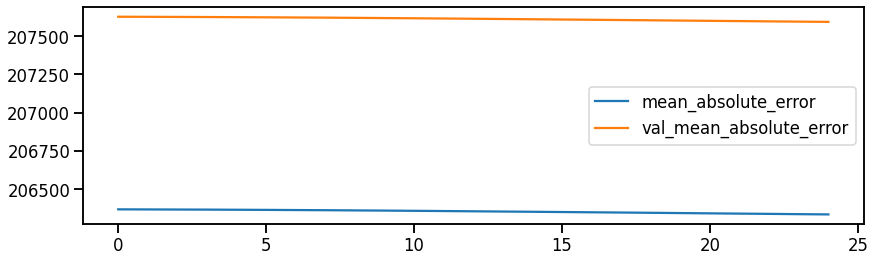

In [28]:
print(history.history.keys())
plt.figure(figsize=(14, 4))
series = history.history["mean_absolute_error"]
plt.plot(range(len(series)), series, label="mean_absolute_error")
series = history.history["val_mean_absolute_error"]
plt.plot(range(len(series)), series, label="val_mean_absolute_error")
plt.legend()
plt.show()

In [29]:
network.evaluate(X_train, y_train)

447/447 [==============================] - 0s 422us/step - loss: 206712.0469 - mean_absolute_error: 206712.0469


[206712.046875, 206712.046875]

In [30]:
network.evaluate(X_test,y_test)

192/192 [==============================] - 0s 434us/step - loss: 207105.3125 - mean_absolute_error: 207105.3125


[207105.3125, 207105.3125]

## Übung:

* Verwende den Code von oben und trainiere das Modell mit Mean-Absolute-Error loss und probiere andere Netzwerk Architekturen aus (mehr Layer, mehr Neuronen usw)
    * keras.losses.MeanAbsoluteError()
    
* Probiere verschiedene Aktivierungsfunktionen für die Neurone. Was ändert sich am Verlauf des Losses?
    * Für eine Liste von Aktivierungsfunktionen siehe https://keras.io/api/layers/activations/#available-activations

## Zusatzübung:

* Skaliere die Zielvariable, so dass die Größenordnung ~1. Verbessert sich dadurch die Performance des Modells?

# Zusatzübung 2:

Die folgenden Daten wurden vorbereitet:

Aufgabe:

* Trainiere ein neuronales Netzwerk welches MPG vorhersagt
* Teste die Performance dem Testdatensatz (80%:20% split)

Hinweis: Dies geht mit "model.evaluate(test_features, test_labels)"

In [31]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(
    url, names=column_names,
    na_values='?', comment='\t',
    sep=' ', skipinitialspace=True
)
dataset = raw_dataset.copy().drop(columns=["Origin"])
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
0,18.0,8,307.0,130.0,3504.0,12.0,70
1,15.0,8,350.0,165.0,3693.0,11.5,70
2,18.0,8,318.0,150.0,3436.0,11.0,70
3,16.0,8,304.0,150.0,3433.0,12.0,70
4,17.0,8,302.0,140.0,3449.0,10.5,70


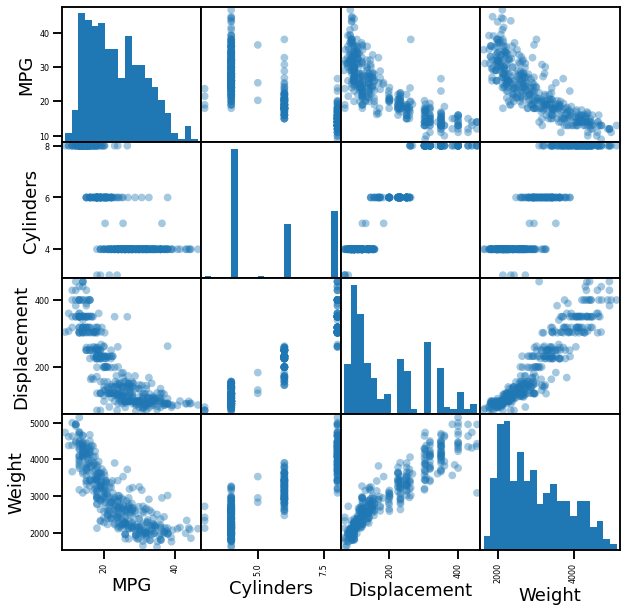

In [32]:
dataset = dataset.dropna()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

pd.plotting.scatter_matrix(
    dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], 
    figsize=(10, 10), marker='o', 
    hist_kwds={'bins': 20},
    s=60, 
    alpha=.4
)
plt.show()

In [33]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


In [34]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [35]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year
146,4,90.0,75.0,2125.0,14.5,74
282,4,140.0,88.0,2890.0,17.3,79
69,8,350.0,160.0,4456.0,13.5,72
378,4,105.0,63.0,2125.0,14.7,82
331,4,97.0,67.0,2145.0,18.0,80
...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79
229,8,400.0,180.0,4220.0,11.1,77
150,4,108.0,93.0,2391.0,15.5,74
145,4,83.0,61.0,2003.0,19.0,74
